In [52]:
!pwd

/Users/ashish1610dhiman/data_projects/fall22_hw/isye6414_group_project/ashish


In [199]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from itertools import combinations
from sklearn.tree import DecisionTreeClassifier

### Prepare data

In [54]:
df_org = pd.read_csv("top_500_artists_deduplicate.csv")
df_org.shape

(4576, 15)

In [55]:
artist_feats = pd.read_csv("ashish_feats.csv")
artist_feats.shape

(4576, 21)

In [56]:
artist_meta = pd.read_csv("../anshit/artist_meta_data.csv")
artist_meta = artist_meta.rename(columns={"name":"artist"})
artist_meta.shape

(726, 5)

In [57]:
artist_feats_joined = artist_feats.merge(artist_meta,on=["artist"],how="left",suffixes=["_","_meta"])
artist_feats_joined.shape

(4576, 25)

#### Create artist other popularity

In [58]:
arist_grp = df_org.groupby(["artist"]).agg({"popularity":["sum","count"]})
arist_grp = arist_grp.reset_index()
arist_grp.columns = ["artist","popularity_sum", "popularity_count"]

In [59]:
joined1 = artist_feats_joined.merge(arist_grp,on=["artist"],how="left",suffixes=["_","_artist"])
joined1.shape

(4576, 27)

#### Create album other popularity

In [60]:
album_grp = df_org.groupby(["album"]).agg({"popularity":["sum","count"]})
album_grp = album_grp.reset_index()
album_grp.columns = ["album","popularity_sum", "popularity_count"]

In [61]:
joined2 = joined1.merge(album_grp,on=["album"],how="left",suffixes=["","_album"])
joined2.shape

(4576, 29)

In [62]:
joined2.columns

Index(['name', 'album', 'artist', 'release_date', 'length', 'popularity_',
       'danceability', 'acousticness', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature',
       'days_since', 'liveness_speechiness_feat',
       'danceability_speechiness_feat', 'length_speechiness_feat',
       'instrumentalness_time_signature_feat', 'length_tempo_feat',
       'Unnamed: 0', 'artist_id', 'popularity_meta', 'followers',
       'popularity_sum', 'popularity_count', 'popularity_sum_album',
       'popularity_count_album'],
      dtype='object')

#### Create Artist and Album popularity agg variables

In [63]:
joined2["artist_avg_pop_other"]=(joined2["popularity_sum"]-joined2["popularity_"])/\
(joined2["popularity_count"]-1)

joined2["album_avg_pop_other"]=(joined2["popularity_sum_album"]-joined2["popularity_"])/\
(joined2["popularity_count_album"]-1)

In [64]:
joined2[["artist_avg_pop_other","album_avg_pop_other"]].isna().sum()

artist_avg_pop_other     197
album_avg_pop_other     2001
dtype: int64

In [65]:
joined2["release_date"] = pd.to_datetime(joined2["release_date"])
joined2["days_since"] = joined2["release_date"].max() - joined2["release_date"]
joined2["days_since"] = joined2["days_since"].dt.days

#### Remove single song artist

In [66]:
mask_single_song_artist = joined2.artist_avg_pop_other.isna()
df_model = joined2[~mask_single_song_artist]
df_model.isna().sum()

name                                       0
album                                      0
artist                                     0
release_date                               0
length                                     0
popularity_                                0
danceability                               0
acousticness                               0
energy                                     0
instrumentalness                           0
liveness                                   0
loudness                                   0
speechiness                                0
tempo                                      0
time_signature                             0
days_since                                 0
liveness_speechiness_feat                  0
danceability_speechiness_feat              0
length_speechiness_feat                    0
instrumentalness_time_signature_feat       0
length_tempo_feat                          0
Unnamed: 0                                17
artist_id 

In [67]:
# mask_na_meta = df_model[["popularity_meta"]].isna()
df_model = df_model.dropna(subset=["popularity_meta"])
df_model.shape

(4362, 31)

In [68]:
df_model.isna().sum()

name                                       0
album                                      0
artist                                     0
release_date                               0
length                                     0
popularity_                                0
danceability                               0
acousticness                               0
energy                                     0
instrumentalness                           0
liveness                                   0
loudness                                   0
speechiness                                0
tempo                                      0
time_signature                             0
days_since                                 0
liveness_speechiness_feat                  0
danceability_speechiness_feat              0
length_speechiness_feat                    0
instrumentalness_time_signature_feat       0
length_tempo_feat                          0
Unnamed: 0                                 0
artist_id 

In [69]:
mask_missing_album_popularity = df_model["album_avg_pop_other"].isna()
df_model["imputed_album_avg_pop_other"] = mask_missing_album_popularity.astype("int")
df_model["album_avg_pop_other"][mask_missing_album_popularity] = df_model["artist_avg_pop_other"\
                                                                         ][mask_missing_album_popularity]

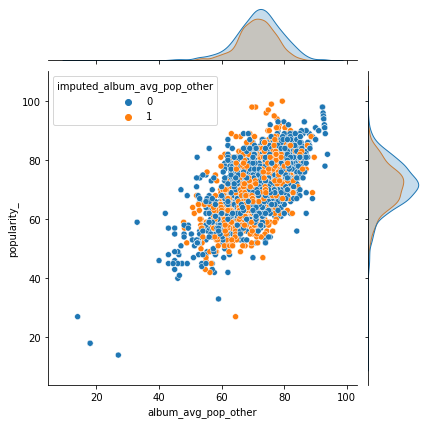

In [70]:
sns.jointplot(data=df_model, x="album_avg_pop_other", y="popularity_", hue="imputed_album_avg_pop_other")

In [71]:
df_model.to_csv("modelling_data_step1.csv")

#### One Hot Encode categorical vars

In [72]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4362 entries, 0 to 4575
Data columns (total 32 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   name                                  4362 non-null   object        
 1   album                                 4362 non-null   object        
 2   artist                                4362 non-null   object        
 3   release_date                          4362 non-null   datetime64[ns]
 4   length                                4362 non-null   int64         
 5   popularity_                           4362 non-null   int64         
 6   danceability                          4362 non-null   float64       
 7   acousticness                          4362 non-null   float64       
 8   energy                                4362 non-null   float64       
 9   instrumentalness                      4362 non-null   float64       
 10  

In [73]:
to_encode = ["time_signature","liveness_speechiness_feat","danceability_speechiness_feat",\
            "length_speechiness_feat","instrumentalness_time_signature_feat","length_tempo_feat"]

In [74]:
def ad_grp(df,x):
    n=len(df)
    df_grp = df.groupby([x])["name"].apply(lambda x: x.count()/n)
    return (df_grp)

for x in to_encode:
    print(ad_grp(df_model,x))
    print()

time_signature
1    0.004585
3    0.047914
4    0.937414
5    0.010087
Name: name, dtype: float64

liveness_speechiness_feat
1.0      0.237047
2.0      0.483494
3.0      0.255617
999.0    0.023842
Name: name, dtype: float64

danceability_speechiness_feat
2.0      0.659789
3.0      0.316369
999.0    0.023842
Name: name, dtype: float64

length_speechiness_feat
2.0      0.702201
3.0      0.255617
5.0      0.018340
999.0    0.023842
Name: name, dtype: float64

instrumentalness_time_signature_feat
1.0      0.005731
2.0      0.960798
3.0      0.009629
999.0    0.023842
Name: name, dtype: float64

length_tempo_feat
1.0      0.010087
2.0      0.959193
5.0      0.006878
999.0    0.023842
Name: name, dtype: float64



In [75]:
encoded_df = pd.get_dummies(df_model,columns = to_encode, drop_first=True)
[x for x in encoded_df.columns if any([z in x for z in to_encode])]

['time_signature_3',
 'time_signature_4',
 'time_signature_5',
 'liveness_speechiness_feat_2.0',
 'liveness_speechiness_feat_3.0',
 'liveness_speechiness_feat_999.0',
 'danceability_speechiness_feat_3.0',
 'danceability_speechiness_feat_999.0',
 'length_speechiness_feat_3.0',
 'length_speechiness_feat_5.0',
 'length_speechiness_feat_999.0',
 'instrumentalness_time_signature_feat_2.0',
 'instrumentalness_time_signature_feat_3.0',
 'instrumentalness_time_signature_feat_999.0',
 'length_tempo_feat_2.0',
 'length_tempo_feat_5.0',
 'length_tempo_feat_999.0']

In [76]:
encoded_df1 = encoded_df.drop(columns=["popularity_sum","popularity_sum_album",\
                                      "name","album","artist","release_date",\
                                      "Unnamed: 0","artist_id"])

In [77]:
encoded_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4362 entries, 0 to 4575
Data columns (total 35 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   length                                      4362 non-null   int64  
 1   popularity_                                 4362 non-null   int64  
 2   danceability                                4362 non-null   float64
 3   acousticness                                4362 non-null   float64
 4   energy                                      4362 non-null   float64
 5   instrumentalness                            4362 non-null   float64
 6   liveness                                    4362 non-null   float64
 7   loudness                                    4362 non-null   float64
 8   speechiness                                 4362 non-null   float64
 9   tempo                                       4362 non-null   float64
 10  days_since  

In [78]:
encoded_df1.to_csv("modelling_data_step2.csv")

#### Log of Days Since

<AxesSubplot:>

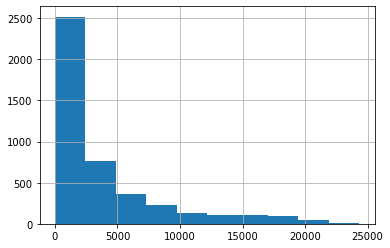

In [79]:
encoded_df1["days_since"].hist()

In [80]:
encoded_df1["days_since_log"] = np.log(encoded_df1["days_since"]+0.001)

<AxesSubplot:>

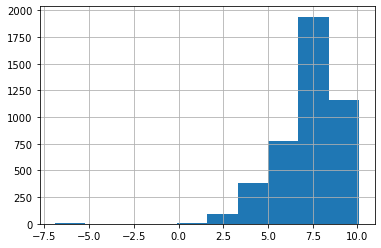

In [81]:
encoded_df1["days_since_log"].hist()

In [82]:
encoded_df1.to_csv("modelling_data_step3.csv")

#### Scatter plot of all X and y

In [83]:
col_subset = [x for x in encoded_df1.columns if all([z not in x for z in ["feat","time_signature","imputed_album"]])]
col_subset

['length',
 'popularity_',
 'danceability',
 'acousticness',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'days_since',
 'popularity_meta',
 'followers',
 'popularity_count',
 'popularity_count_album',
 'artist_avg_pop_other',
 'album_avg_pop_other',
 'days_since_log']

<AxesSubplot:>

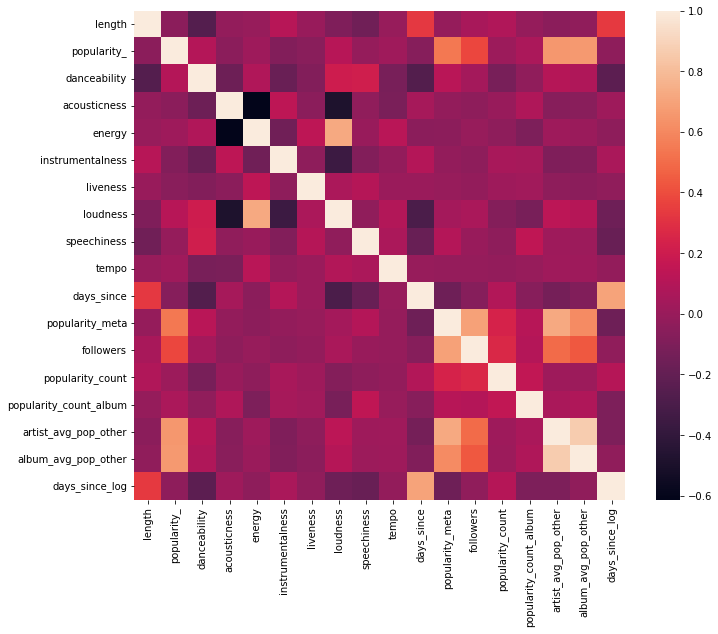

In [84]:
corr = encoded_df1[col_subset].corr()

fig,ax = plt.subplots(figsize=(11,9))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### feature engineering

In [85]:
encoded_df1["acousticness_loudness"]= encoded_df1["acousticness"]/np.square(encoded_df1["loudness"])

In [86]:
encoded_df1["instrumentalness_loudness"]= encoded_df1["instrumentalness"]/np.square(encoded_df1["loudness"])

In [87]:
encoded_df1["instrumentalness_acousticness"]= encoded_df1["instrumentalness"]*encoded_df1["acousticness"]

In [98]:
encoded_df1["followers_root"]= encoded_df1["followers"]**0.5

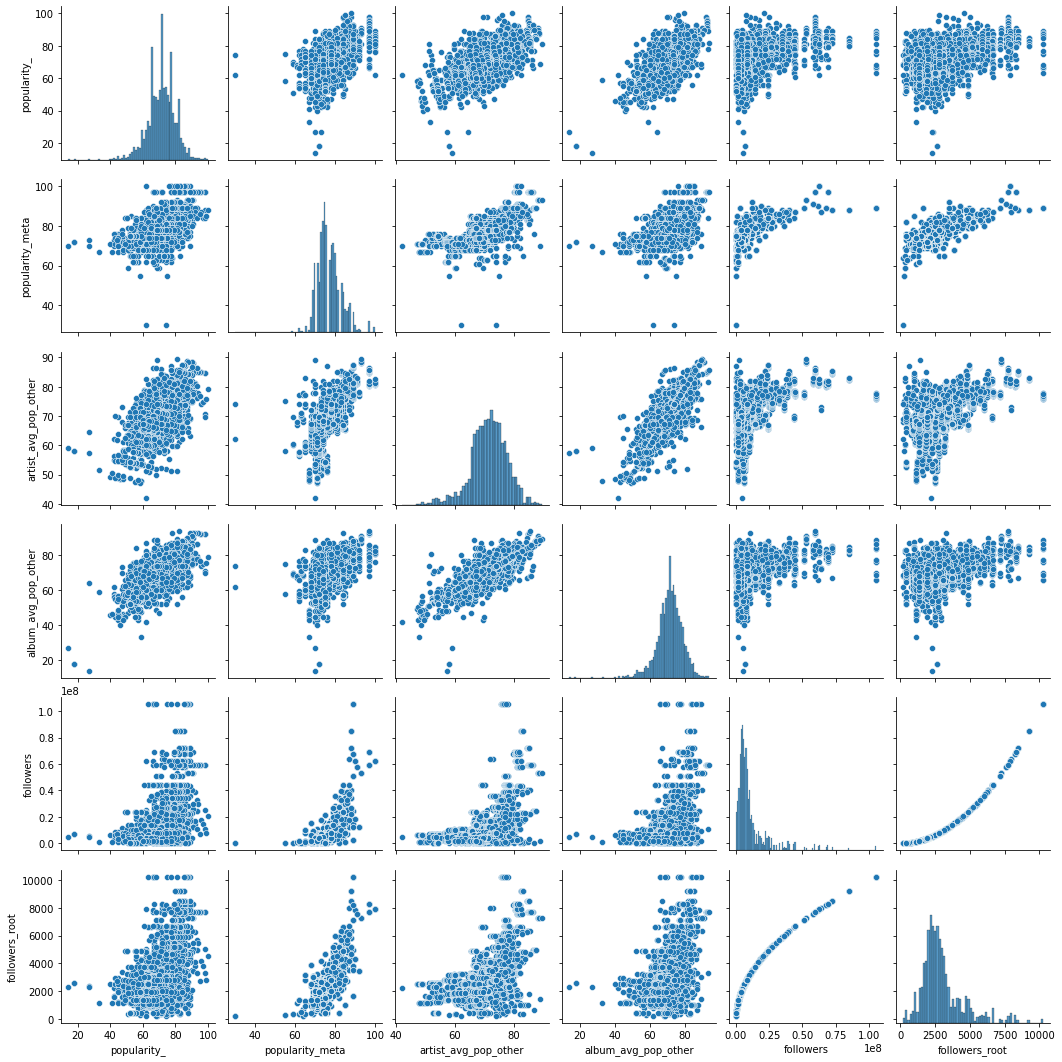

In [99]:
sns.pairplot(encoded_df1[["popularity_","popularity_meta","artist_avg_pop_other","album_avg_pop_other",\
                          "followers","followers_root"]])

In [100]:
encoded_df1.to_csv("modelling_data_step3.csv")

### Vanilla Model

In [102]:
X_cols = [x for x in encoded_df1.columns if x!="popularity_"]
y_col = "popularity_"
X_cols

['length',
 'danceability',
 'acousticness',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'days_since',
 'popularity_meta',
 'followers',
 'popularity_count',
 'popularity_count_album',
 'artist_avg_pop_other',
 'album_avg_pop_other',
 'imputed_album_avg_pop_other',
 'time_signature_3',
 'time_signature_4',
 'time_signature_5',
 'liveness_speechiness_feat_2.0',
 'liveness_speechiness_feat_3.0',
 'liveness_speechiness_feat_999.0',
 'danceability_speechiness_feat_3.0',
 'danceability_speechiness_feat_999.0',
 'length_speechiness_feat_3.0',
 'length_speechiness_feat_5.0',
 'length_speechiness_feat_999.0',
 'instrumentalness_time_signature_feat_2.0',
 'instrumentalness_time_signature_feat_3.0',
 'instrumentalness_time_signature_feat_999.0',
 'length_tempo_feat_2.0',
 'length_tempo_feat_5.0',
 'length_tempo_feat_999.0',
 'days_since_log',
 'acousticness_loudness',
 'instrumentalness_loudness',
 'instrumentalness_acousticness',
 'followers_root']

In [155]:
days_since_mask = encoded_df1.days_since <=60
days_since_mask.sum()

247

In [156]:
X = encoded_df1.loc[days_since_mask][X_cols]
y = encoded_df1.loc[days_since_mask][y_col]

In [167]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)
X_scaled.columns = X.columns

In [170]:
X_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 39 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   length                                      247 non-null    float64
 1   danceability                                247 non-null    float64
 2   acousticness                                247 non-null    float64
 3   energy                                      247 non-null    float64
 4   instrumentalness                            247 non-null    float64
 5   liveness                                    247 non-null    float64
 6   loudness                                    247 non-null    float64
 7   speechiness                                 247 non-null    float64
 8   tempo                                       247 non-null    float64
 9   days_since                                  247 non-null    float64
 10  popularity_met

In [171]:
X_scaled

,length,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,days_since,...,instrumentalness_time_signature_feat_3.0,instrumentalness_time_signature_feat_999.0,length_tempo_feat_2.0,length_tempo_feat_5.0,length_tempo_feat_999.0,days_since_log,acousticness_loudness,instrumentalness_loudness,instrumentalness_acousticness,followers_root
0,0.226972,0.582133,0.072131,0.349869,0.000000,0.319552,0.673101,0.060000,0.527735,0.859649,...,0.0,0.0,1.0,0.0,0.0,0.986190,0.012445,0.000000,0.000000,0.264550
1,0.300697,0.433718,0.057120,0.815927,0.000000,0.149440,0.973350,0.014652,0.485774,0.263158,...,0.0,0.0,1.0,0.0,0.0,0.878096,0.326055,0.000000,0.000000,1.000000
2,0.170358,0.876081,0.668464,0.476501,0.000016,0.073105,0.788418,0.006845,0.352801,0.140351,...,0.0,0.0,1.0,0.0,0.0,0.820698,0.247692,0.000008,0.000038,0.398869
3,0.274937,0.912104,0.164140,0.757180,0.000053,0.093454,0.835791,0.068877,0.328306,0.403509,...,0.0,1.0,0.0,0.0,1.0,0.917127,0.092898,0.000040,0.000031,0.029428
4,0.246898,0.674352,0.030122,0.656658,0.000320,0.067722,0.678371,0.009519,0.491600,0.368421,...,0.0,0.0,1.0,0.0,0.0,0.908820,0.005343,0.000076,0.000034,0.365519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,0.026689,0.547550,0.629587,0.344648,0.000000,0.654393,0.317424,0.987166,0.219230,0.614035,...,0.0,0.0,0.0,1.0,0.0,0.955465,0.027765,0.000000,0.000000,0.012978
243,0.030532,0.677233,0.850971,0.308094,0.000000,0.498277,0.314131,1.000000,0.143342,0.614035,...,0.0,0.0,0.0,1.0,0.0,0.955465,0.037192,0.000000,0.000000,0.012978
244,0.027695,0.610951,0.695462,0.343342,0.000000,0.308786,0.247606,0.966845,0.376831,0.614035,...,0.0,0.0,0.0,1.0,0.0,0.955465,0.025481,0.000000,0.000000,0.012978
245,0.027946,0.632565,0.637146,0.407311,0.000000,0.739449,0.275523,0.967914,0.518152,0.614035,...,0.0,0.0,0.0,1.0,0.0,0.955465,0.025088,0.000000,0.000000,0.012978


In [174]:
X_scaled_1 = sm.add_constant(X_scaled)
X_scaled_1.index = y.index

In [175]:
model = sm.OLS(y, X_scaled_1)
results = model.fit()
results.rsquared

0.6853621123394524

In [176]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            popularity_   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     15.11
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           1.07e-38
Time:                        18:37:09   Log-Likelihood:                -768.27
No. Observations:                 247   AIC:                             1601.
Df Residuals:                     215   BIC:                             1713.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                         20.1692      5.547      3.636      0.000       9.236      31.102
length                                        -6.4982      4.848     -1.341      0.181     -16.053       3.057
danceability                                   0.0792      2.395      0.033      0.974      -4.642       4.800
acousticness                                  -0.7187      2.850     -0.252      0.801      -6.336       4.898
energy                                        -3.7760      3.047     -1.239      0.217      -9.782       2.230
instrumentalness                              12.6152      7.998      1.577      0.116      -3.149      28.379
liveness                                       1.5767      2.517      0.627      0.532      -3.384       6.537
loudness                                      11.7989      6.147      1.920      0.056      -0.317      23.915
speechiness                                    2.3517      4.026      0.584      0.560      -5.584      10.287
tempo                                         -7.1755      2.367     -3.032      0.003     -11.841      -2.510
days_since                                     2.8295      1.837      1.541      0.125      -0.790       6.450
popularity_meta                               17.1241      4.136      4.140      0.000       8.972      25.276
followers                                      7.4146     12.404      0.598      0.551     -17.034      31.863
popularity_count                               3.7524      5.612      0.669      0.504      -7.309      14.814
popularity_count_album                        -1.5721      3.144     -0.500      0.618      -7.770       4.626
artist_avg_pop_other                          -6.0799      7.211     -0.843      0.400     -20.294       8.134
album_avg_pop_other                           30.5589      6.758      4.522      0.000      17.238      43.880
imputed_album_avg_pop_other                    1.6590      1.588      1.045      0.297      -1.470       4.788
time_signature_3                              -4.3924      7.137     -0.615      0.539     -18.459       9.674
time_signature_4                              -4.0100      7.034     -0.570      0.569     -17.874       9.854
time_signature_5                              -2.0989      7.848     -0.267      0.789     -17.567      13.369
liveness_speechiness_feat_2.0                 -0.9218      1.320     -0.698      0.486      -3.523       1.680
liveness_speechiness_feat_3.0                  1.5383      0.915      1.681      0.094      -0.266       3.342
liveness_speechiness_feat_999.0                4.6296      1.013      4.568      0.000       2.632       6.627
danceability_speechiness_feat_3.0             -4.3326      1.887     -2.296      0.023

### Feature Selection

In [185]:
frames = []
alpha_range = np.arange(0.01, 1, 0.02).tolist()
for n in alpha_range: #loop over alpha hyperparam
    results_lasso = model.fit_regularized(L1_wt=1, alpha=n, start_params=results.params)#Lasso

    results_lasso_fit = sm.regression.linear_model.OLSResults(model, 
                                                           results_lasso.params, 
                                                           model.normalized_cov_params)
    lasso_params=pd.Series(results_lasso.params)
    columns_lasso=list(lasso_params[lasso_params!=0].index)
    non_zero = len(columns_lasso)
    frames.append(np.append(results.params,\
                            np.append(results_lasso_fit.ssr,np.append(results_lasso_fit.rsquared,\
                                                                      np.append(results_lasso_fit.rsquared_adj,non_zero)))))

    df = pd.DataFrame(frames, columns=list(X_scaled_1.columns) +['ssr'] +['r-squared']+['adjusted-r-squared']\
                     +["non_zero_cols"])
df.index=alpha_range
df.index.name = 'alpha*'
# df.T

Text(0.5, 1.0, 'SSR')

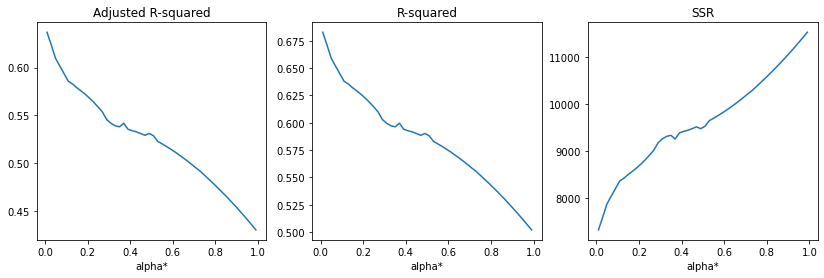

In [179]:
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

ax[0] = df.iloc[:, -1].plot(ax=ax[0])
ax[0].set_title('Adjusted R-squared')

ax[1] = df.iloc[:, -2].plot(ax=ax[1])
ax[1].set_title('R-squared')

ax[2] = df.iloc[:, -3].plot(ax=ax[2])
ax[2].set_title('SSR')

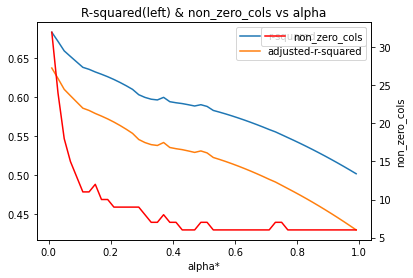

In [188]:
df[["r-squared","adjusted-r-squared"]].plot()
ax2 = plt.twinx()
sns.lineplot(data=df["non_zero_cols"], color="r",\
             label="non_zero_cols", ax=ax2)
plt.title("R-squared(left) & non_zero_cols vs alpha")
plt.legend()

##### Zoom on 0.0 to 0.2

In [191]:
frames = []
alpha_range = np.arange(0.01, 0.2, 0.005).tolist()
for n in alpha_range: #loop over alpha hyperparam
    results_lasso = model.fit_regularized(L1_wt=1, alpha=n, start_params=results.params)#Lasso

    results_lasso_fit = sm.regression.linear_model.OLSResults(model, 
                                                           results_lasso.params, 
                                                           model.normalized_cov_params)
    lasso_params=pd.Series(results_lasso.params)
    columns_lasso=list(lasso_params[lasso_params!=0].index)
    non_zero = len(columns_lasso)
    frames.append(np.append(results.params,\
                            np.append(results_lasso_fit.ssr,np.append(results_lasso_fit.rsquared,\
                                                                      np.append(results_lasso_fit.rsquared_adj,non_zero)))))

    df_zoom = pd.DataFrame(frames, columns=list(X_scaled_1.columns) +['ssr'] +['r-squared']+['adjusted-r-squared']\
                     +["non_zero_cols"])
df_zoom.index=alpha_range
df_zoom.index.name = 'alpha*'
# df.T

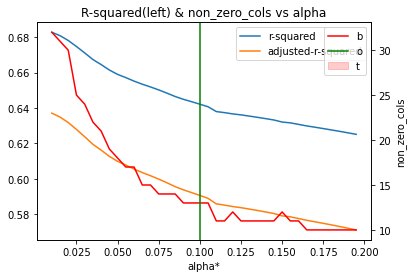

In [195]:
df_zoom[["r-squared","adjusted-r-squared"]].plot()
ax2 = plt.twinx()
sns.lineplot(data=df_zoom["non_zero_cols"], color="r",\
             label="non_zero_cols", ax=ax2)
plt.title("R-squared(left) & non_zero_cols vs alpha")
plt.axvline(x=0.1,c="g",label="alpha = 0.1")
plt.legend("bottom")

### Observing the above plots , it make sense to go ahead with a lasso regularized model (as a feature selection technique) for alpha = 0.1

In [196]:
results_lasso = model.fit_regularized(L1_wt=1, alpha=0.1, start_params=results.params)
final = sm.regression.linear_model.OLSResults(model, 
                                              results_lasso.params, 
                                              model.normalized_cov_params)

final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            popularity_   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     12.44
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           4.32e-33
Time:                        18:50:46   Log-Likelihood:                -784.17
No. Observations:                 247   AIC:                             1632.
Df Residuals:                     215   BIC:                             1745.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                         23.0389      5.916      3.894      0.000      11.379      34.699
length                                              0      5.170          0      1.000     -10.190      10.190
danceability                                        0      2.555          0      1.000      -5.035       5.035
acousticness                                        0      3.039          0      1.000      -5.991       5.991
energy                                              0      3.250          0      1.000      -6.406       6.406
instrumentalness                                    0      8.530          0      1.000     -16.812      16.812
liveness                                            0      2.684          0      1.000      -5.290       5.290
loudness                                       3.3286      6.556      0.508      0.612      -9.593      16.250
speechiness                                         0      4.294          0      1.000      -8.463       8.463
tempo                                         -0.7425      2.524     -0.294      0.769      -5.718       4.233
days_since                                          0      1.959          0      1.000      -3.861       3.861
popularity_meta                               14.9496      4.411      3.389      0.001       6.256      23.644
followers                                           0     13.229          0      1.000     -26.075      26.075
popularity_count                                    0      5.985          0      1.000     -11.797      11.797
popularity_count_album                              0      3.354          0      1.000      -6.610       6.610
artist_avg_pop_other                                0      7.691          0      1.000     -15.160      15.160
album_avg_pop_other                           24.8022      7.208      3.441      0.001      10.595      39.009
imputed_album_avg_pop_other                    2.7371      1.693      1.617      0.107      -0.600       6.074
time_signature_3                                    0      7.611          0      1.000     -15.002      15.002
time_signature_4                                    0      7.501          0      1.000     -14.786      14.786
time_signature_5                                    0      8.370          0      1.000     -16.497      16.497
liveness_speechiness_feat_2.0                       0      1.408          0      1.000      -2.774       2.774
liveness_speechiness_feat_3.0                       0      0.976          0      1.000      -1.924       1.924
liveness_speechiness_feat_999.0                     0      1.081          0      1.000      -2.131       2.131
danceability_speechiness_feat_3.0             -0.5164      2.012     -0.257      0.798

In [214]:
lasso_params=pd.Series(results_lasso.params)
columns_lasso=list(lasso_params[lasso_params!=0].index)
columns_lasso

['const',
 'loudness',
 'tempo',
 'popularity_meta',
 'album_avg_pop_other',
 'imputed_album_avg_pop_other',
 'danceability_speechiness_feat_3.0',
 'length_speechiness_feat_999.0',
 'instrumentalness_time_signature_feat_2.0',
 'instrumentalness_time_signature_feat_999.0',
 'length_tempo_feat_2.0',
 'length_tempo_feat_999.0',
 'days_since_log']

### Analyzing Variance Inflation factor to check for multicollinearity (overall model)

In [203]:
vif_full = pd.DataFrame()
vif_full['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_full['variable'] = X.columns
vif_full.sort_values(by="VIF",ascending=False)

/Users/ashish1610dhiman/opt/anaconda3/envs/spotify_app/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/Users/ashish1610dhiman/opt/anaconda3/envs/spotify_app/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF,variable
27,inf,length_speechiness_feat_999.0
28,inf,instrumentalness_time_signature_feat_2.0
24,inf,danceability_speechiness_feat_999.0
25,inf,length_speechiness_feat_3.0
21,inf,liveness_speechiness_feat_3.0
22,inf,liveness_speechiness_feat_999.0
30,inf,instrumentalness_time_signature_feat_999.0
31,inf,length_tempo_feat_2.0
32,inf,length_tempo_feat_5.0
33,inf,length_tempo_feat_999.0


In [207]:
X.values.shape

(247, 39)

In [213]:
X_lasso

,const,loudness,tempo,popularity_meta,album_avg_pop_other,imputed_album_avg_pop_other,danceability_speechiness_feat_3.0,length_speechiness_feat_999.0,instrumentalness_time_signature_feat_2.0,instrumentalness_time_signature_feat_999.0,length_tempo_feat_2.0,length_tempo_feat_999.0,days_since_log
9,1.0,-7.174,129.974,78.0,75.000000,0,0,0,1,0,1,0,3.891841
26,1.0,-1.248,123.038,89.0,76.083333,1,1,0,1,0,1,0,2.708117
88,1.0,-4.898,101.058,83.0,61.800000,0,1,0,1,0,1,0,2.079567
105,1.0,-3.963,97.009,76.0,87.000000,1,0,1,0,1,0,1,3.135538
190,1.0,-7.070,124.001,85.0,75.000000,1,1,0,1,0,1,0,3.044570
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4561,1.0,-14.194,78.979,75.0,52.000000,0,0,0,1,0,0,0,3.555377
4562,1.0,-14.259,66.435,75.0,52.250000,0,0,0,1,0,0,0,3.555377
4563,1.0,-15.572,105.030,75.0,52.250000,0,0,0,1,0,0,0,3.555377
4564,1.0,-15.021,128.390,75.0,52.250000,0,0,0,1,0,0,0,3.555377


In [212]:
columns_lasso

['const',
 'loudness',
 'tempo',
 'popularity_meta',
 'album_avg_pop_other',
 'imputed_album_avg_pop_other',
 'danceability_speechiness_feat_3.0',
 'length_speechiness_feat_999.0',
 'instrumentalness_time_signature_feat_2.0',
 'instrumentalness_time_signature_feat_999.0',
 'length_tempo_feat_2.0',
 'length_tempo_feat_999.0',
 'days_since_log']

In [229]:
[x for x in columns_lasso if "const" not in x]

['loudness',
 'tempo',
 'popularity_meta',
 'album_avg_pop_other',
 'imputed_album_avg_pop_other',
 'danceability_speechiness_feat_3.0',
 'length_speechiness_feat_999.0',
 'instrumentalness_time_signature_feat_2.0',
 'instrumentalness_time_signature_feat_999.0',
 'length_tempo_feat_2.0',
 'length_tempo_feat_999.0',
 'days_since_log']

In [232]:
X_lasso=sm.add_constant(X)[[x for x in columns_lasso if all([z not in x for z in ["const1","feat"]])]]
vif_lasso = pd.DataFrame()
vif_lasso['VIF'] = [variance_inflation_factor(X_lasso.values, i) for i in range(X_lasso.shape[1])]
vif_lasso['variable'] = X_lasso.columns
vif_lasso.sort_values(by="VIF",ascending=False)

,VIF,variable
0,272.969828,const
4,2.006594,album_avg_pop_other
3,1.448989,popularity_meta
1,1.349130,loudness
5,1.213831,imputed_album_avg_pop_other
2,1.089849,tempo
6,1.071862,days_since_log


#### Corr plot of above variables

In [236]:
X_lasso

,const,loudness,tempo,popularity_meta,album_avg_pop_other,imputed_album_avg_pop_other,days_since_log
9,1.0,-7.174,129.974,78.0,75.000000,0,3.891841
26,1.0,-1.248,123.038,89.0,76.083333,1,2.708117
88,1.0,-4.898,101.058,83.0,61.800000,0,2.079567
105,1.0,-3.963,97.009,76.0,87.000000,1,3.135538
190,1.0,-7.070,124.001,85.0,75.000000,1,3.044570
...,...,...,...,...,...,...,...
4561,1.0,-14.194,78.979,75.0,52.000000,0,3.555377
4562,1.0,-14.259,66.435,75.0,52.250000,0,3.555377
4563,1.0,-15.572,105.030,75.0,52.250000,0,3.555377
4564,1.0,-15.021,128.390,75.0,52.250000,0,3.555377


<AxesSubplot:>

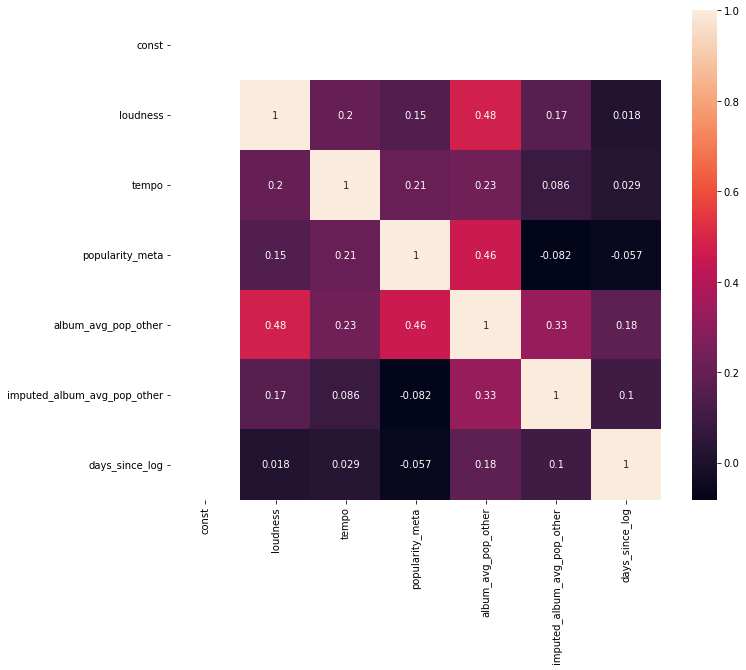

In [235]:
corr_lasso = X_lasso.corr()

fig,ax = plt.subplots(figsize=(11,9))
sns.heatmap(corr_lasso,annot=True,
            xticklabels=corr_lasso.columns.values,
            yticklabels=corr_lasso.columns.values)

In [239]:
def highlighter(cell_value):
    if cell_value>0.4 and cell_value!=1.0:
        return "background-color: yellow"

corr_lasso.style.applymap(highlighter)

,const,loudness,tempo,popularity_meta,album_avg_pop_other,imputed_album_avg_pop_other,days_since_log
const,nan,nan,nan,nan,nan,nan,nan
loudness,nan,1.000000,0.202939,0.147773,0.482875,0.170789,0.017885
tempo,nan,0.202939,1.000000,0.209184,0.228881,0.086385,0.028641
popularity_meta,nan,0.147773,0.209184,1.000000,0.458725,-0.081678,-0.057230
album_avg_pop_other,nan,0.482875,0.228881,0.458725,1.000000,0.326036,0.181114
imputed_album_avg_pop_other,nan,0.170789,0.086385,-0.081678,0.326036,1.000000,0.104130
days_since_log,nan,0.017885,0.028641,-0.057230,0.181114,0.104130,1.000000


In [244]:
X_new = X_lasso.copy()
X_new["popularity_meta_album_avg_pop_other"] = X_new["album_avg_pop_other"]*X_new["popularity_meta"]
X_new = X_new.drop(columns=["album_avg_pop_other","popularity_meta"])
X_new

,const,loudness,tempo,imputed_album_avg_pop_other,days_since_log,popularity_meta_album_avg_pop_other
9,1.0,-7.174,129.974,0,3.891841,5850.000000
26,1.0,-1.248,123.038,1,2.708117,6771.416667
88,1.0,-4.898,101.058,0,2.079567,5129.400000
105,1.0,-3.963,97.009,1,3.135538,6612.000000
190,1.0,-7.070,124.001,1,3.044570,6375.000000
...,...,...,...,...,...,...
4561,1.0,-14.194,78.979,0,3.555377,3900.000000
4562,1.0,-14.259,66.435,0,3.555377,3918.750000
4563,1.0,-15.572,105.030,0,3.555377,3918.750000
4564,1.0,-15.021,128.390,0,3.555377,3918.750000


In [245]:
final_model2 = sm.OLS(y, X_new)
results2 = final_model2.fit()
results2.rsquared

0.6507281282244872

In [246]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            popularity_   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     89.80
Date:                Sun, 27 Nov 2022   Prob (F-statistic):           4.77e-53
Time:                        19:16:22   Log-Likelihood:                -781.16
No. Observations:                 247   AIC:                             1574.
Df Residuals:                     241   BIC:                             1595.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                  32.3114      3.253      9.932      0.000      25.903      38.720
loudness                                0.4716      0.127      3.728      0.000       0.222       0.721
tempo                                  -0.0325      0.013     -2.548      0.011      -0.058      -0.007
imputed_album_avg_pop_other             3.0728      0.760      4.042      0.000       1.575       4.571
days_since_log                          0.6787      0.163      4.172      0.000       0.358       0.999
popularity_meta_album_avg_pop_other     0.0077      0.000     15.463      0.000       0.007       0.009
==============================================================================
Omnibus:                       31.978   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.862
Skew:                          -0.384   Prob(JB):                     2.33e-29
Kurtosis:                       6.496   Cond. No.                     4.86e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.86e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [247]:
X_new.to_csv("data_final_after_lasso_vif.csv",index=False)

In [248]:
X_new.columns

Index(['const', 'loudness', 'tempo', 'imputed_album_avg_pop_other',
       'days_since_log', 'popularity_meta_album_avg_pop_other'],
      dtype='object')

### Threshold Analysis for Final 6 variables

In [253]:
encoded_df1["popularity_meta_album_avg_pop_other"] = encoded_df1["album_avg_pop_other"]*encoded_df1["popularity_meta"]
encoded_df1 = sm.add_constant(encoded_df1)
X_cols = X_new.columns
y_col = "popularity_"

In [252]:
def threshold_analysis(df,threshold):
    days_since_mask = df.days_since <=threshold
    X_filtered = df.loc[days_since_mask][X_cols]
    y_filtered = df.loc[days_since_mask][y_col]
    model_filtered = sm.OLS(y_filtered, X_filtered)
    results_filtered=model_filtered.fit()
    return {'threshold':threshold,'rsquared':results_filtered.rsquared,\
            'adjusted-rsquared':results_filtered.rsquared_adj}

In [257]:
r_sq_final=[]
for thresh in np.arange(30,5000,100):
    r_sq_final.append(threshold_analysis(encoded_df1,thresh))

df_r_sq_final=pd.DataFrame.from_dict(r_sq_final)

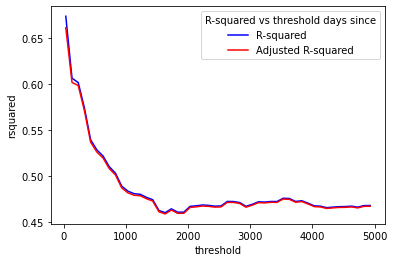

In [258]:
sns.lineplot(x="threshold",y="rsquared",data=df_r_sq_final[["threshold","rsquared"]],color="blue")
sns.lineplot(x="threshold",y="adjusted-rsquared",data=df_r_sq_final[["threshold","adjusted-rsquared"]],color="red")
plt.legend(title='R-squared vs threshold days since', loc='upper right', labels=['R-squared', 'Adjusted R-squared'])

In [ ]:
# r_squared_lasso=[]
# r_squared_lasso_feature_eng=[]

In [182]:
# lasso_params=pd.Series(results_lasso.params)
# columns_lasso=list(lasso_params[lasso_params!=0].index)
# X_lasso=X_scaled_1[columns_lasso]

In [184]:
# columns_lasso

['const',
 'popularity_meta',
 'album_avg_pop_other',
 'imputed_album_avg_pop_other',
 'length_tempo_feat_2.0',
 'days_since_log']